<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/sqt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# X. Li. 2021
# Reference: gwpy; pycbc
! pip install -q 'gwpy==1.0.1'
import numpy as np
import gwpy
from scipy.interpolate import (interp2d, InterpolatedUnivariateSpline)
from pdb import set_trace

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
print("GW170817 data")
print(ldata)

GW170817 GPS: 1187008882.4
GW170817 data
TimeSeries([2.06056010e-20, 1.59181918e-20, 2.18438811e-20, ...,
            1.25504332e-19, 1.23976846e-19, 1.22231459e-19]
           unit: dimensionless,
           t0: 1187008370.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


### Q Transform:

#### 1 Reference Structure

In [4]:
# Reference Analysis
# https://github.com/gwpy/gwpy/blob/v2.0.4/gwpy/timeseries/timeseries.py#L2120
# https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/signal/qtransform.py#L86
# https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/signal/qtransform.py#L117
# https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/spectrogram/spectrogram.py#L61
# gwpy (v2.0.4) 
#   --> timeseries.py 
#         --> q_transform(L-2120) <-- .frequencyseries.FrequencySeries(L-2259)
#                                       <-- window = asd_kw.pop(window type)(L-2262)  
#                                       <-- fftlength
#                                       <-- recommended_overlap(L-2270) <-- signal.window.py
#                                       <-- asd(L-2271) <-- timeseries.py(L-302)
#                                       <-- instance(frequencyseries)(L-2272)
#                                           <-- whiten(L-1669)
#                                       <-- Segment(L-2283) <-- segments.segments.py(L-37)
#                                 **key <-- .qtransform.q_scan <-- signal.qtransform(L-635) 
#                                                Transform data by scanning over a `QTiling`
#                                               'TimeSeries.q_transform is the wrapper of q_scan'
#                                      **key <-- QTiling(L-685) <-- Class QTailing(L-86)
#                                            return a raw Q-transform and its significance
#                                            ----------------------------------------------------------------------------
#                                            ** Note: QTiling __init__ -->
#                                               qlist = list(self._iter_qs())
#                                                if self.frange[0] == 0:  # set non-zero lower frequency
#                                                    self.frange[0] = 50 * max(qlist) / (2 * pi * self.duration)
#                                                maxf = self.sampling / 2 / (1 + 11**(1/2.) / min(qlist))
#                                                if isinf(self.frange[1]):
#                                                    self.frange[1] = maxf
#                                                elif self.frange[1] > maxf:  # truncate upper frequency to maximum
#                                                    warnings.warn('upper frequency of %.2f is too high for the given '
#                                                                  'Q range, resetting to %.2f'
#                                                                 % (self.frange[1], maxf))
#                                                    self.frange[1] = maxf   
#                                            ----------------------------------------------------------------------------
#
#              --> qgram.interpolate <-- signal.qtransform.py(L-488) <-- qgram class(L-453)
#                          |
#                        ^ | ^
#                          ^
#              --> signal.qtransform.py
#                 -->interpolate(L-488) 'Interpolate this `QGram` over a regularly-gridded spectrogram'
#                                       out : `~gwpy.spectrogram.Spectrogram`
#                                                 output `Spectrogram` of normalised Q energy
#                        --> scipy.interpolate(interp2d, InterpolatedUnivariateSpline)(L-539)
#                            Interpolate this `QGram` over a regularly-gridded spectrogram
#                        --> out = Spectrogram(L-552) <-- spectrogram.spectrogram.py(L-61)
#                                     |
#                                   ^ | ^
#                                     ^
#                                 __new__(cls, data, unit=None, t0=None, dt=None, f0=None, df=None,
#                                  times=None, frequencies=None,
#                                  name=None, channel=None, **kwargs):(L-131)
#                          """Generate a new Spectrogram.
#                          """
#                          generate Spectrogram
#                                        return super().__new__(cls, data, unit=unit, name=name,
#                                                              channel=channel, **kwargs)(L-160)
#                             --> out.q = self.plane.q(L-555)
#
#                         --> rnumerate(self.energies)
#                         --> InterpolatedUnivariateSpline(xrow, row.value)(L-539) <-- Scipy
#                         --> (optional)  interp2d() <-- Scipy
#                         --> geomspace <-- Scipy
#                            --> out.q = self.plane.q(L-588)
#                 --> new <-- interpolated out


In [5]:
segment = (int(gps) - 30, int(gps) + 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]


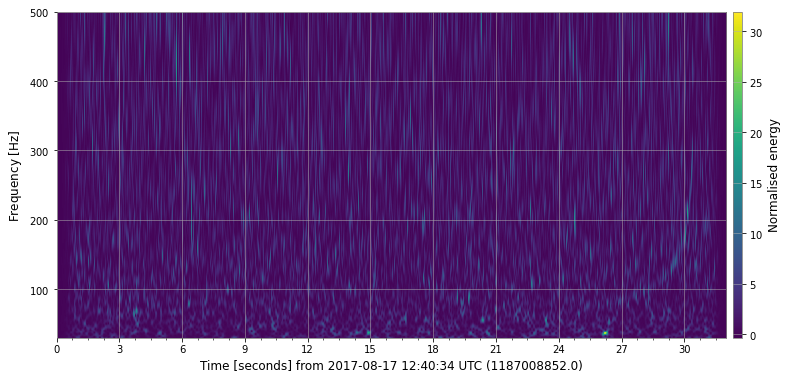

In [6]:
hq = hdata.q_transform(frange=(30, 500),search=None)
#default qrange = (4, 64)

plot = hq.plot()
plot.colorbar(label="Normalised energy")

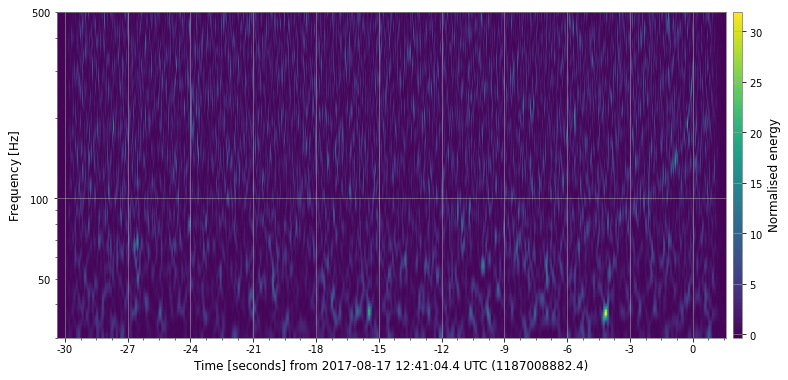

In [7]:
ax = plot.gca()
ax.set_epoch(gps)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot

##### 1.1 Note: numpy.array & PyCBC timeseries <--> gwpy.timeseries Transformation

TimeSeries([ 1.        ,  0.95105648,  0.8090165 , ...,
            -0.99996405,  0.9999929 , -0.99999956]
           unit: m,
           t0: 0.0 s,
           dt: 0.01 s,
           name: None,
           channel: None)


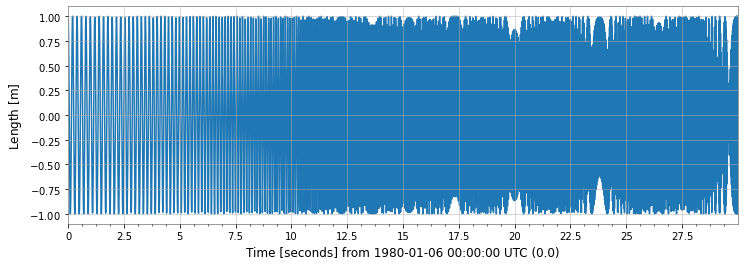

In [8]:
# Generate np.array chirp signal
dt = 0.001
t = np.arange(0,3,dt)
f0 = 50
f1 = 250
t1 = 2
x = np.cos(2*np.pi*t*(f0 + (f1 - f0)*np.power(t, 2)/(3*t1**2)))

fs = 1/dt
#x = x[:int(0.8*(len(x)))]
series = TimeSeries(x, sample_rate=100, unit='m')
print(series)
plot = series.plot()
plot.show()

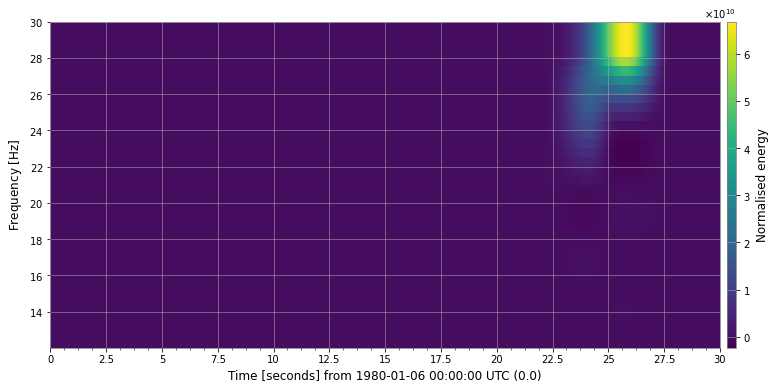

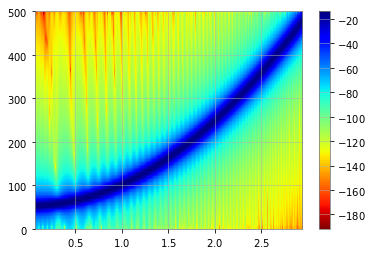

In [9]:
new_series = series.q_transform(frange=(0, 30))
#default qrange = (4, 64)

plot = new_series.plot()
plot.colorbar(label="Normalised energy")
plt.show()

plt.specgram(x, NFFT=128, Fs=1/dt, noverlap=120, cmap='jet_r')
plt.colorbar()
plt.show()

##### 1.2 Pycbc timeseries to np.ndarray

In [10]:
# -- Use the following line if running in Google Colab
# https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
from pycbc.waveform import get_td_waveform
from pycbc.types.timeseries import TimeSeries as cbcTimeSeries
import pylab

In [11]:
import matplotlib.pyplot as plt

In [12]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=5)

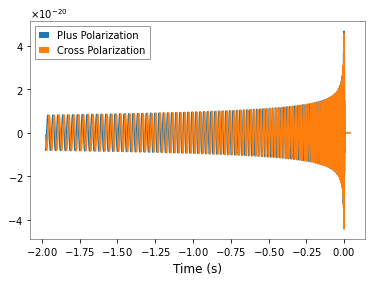

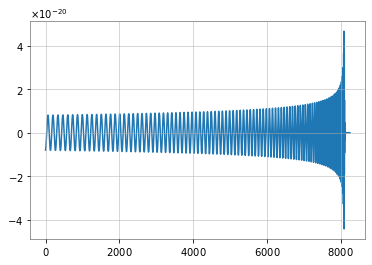

In [13]:
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# verify container type and data extraction
testing_container = np.zeros(2, dtype=object)
testing_container[0], testing_container[1] = hp, hc
print(testing_container)

sample_times = property(hp.get_sample_times, doc="Array containing the sample times.")
np_hp = np.vstack((hp.sample_times.numpy(), hp.numpy()))[1]        #pycbc.timeseries --> numpy.ndarray
plt.clf()
plt.plot(np_hp)
plt.show()

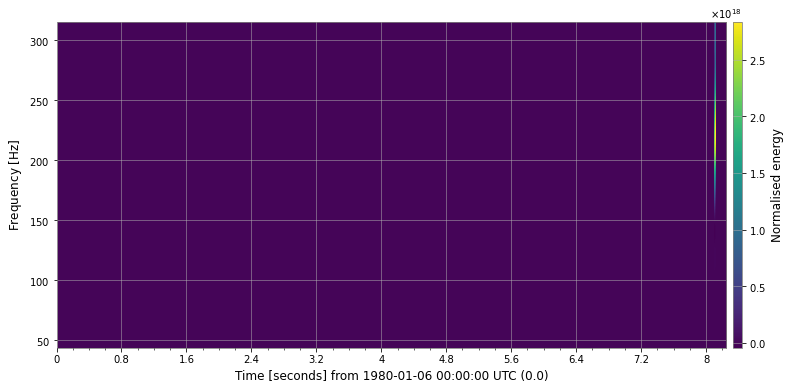

In [14]:
# npumpy.ndarray to gwpy timeseries
np_hp = TimeSeries(np_hp, sample_rate=1000 )
new_series = np_hp.q_transform()
#default qrange = (4, 64)

plot = new_series.plot()
plot.colorbar(label="Normalised energy")
plt.show()

#### 2 Modifications

In [15]:
DEFAULT_QRANGE=[80, 100]
DEFAULT_FRANGE=[30, 500]
DEFAULT_MISMATCH=0.2

##### Dev. Cat. 3 - 1 Q Preps Layer 3; RO -

In [16]:
class QObject(object):
    """Base class for Q-transform objects
    This object exists just to provide basic methods for all other
    Q-transform objects.
    """
    # pylint: disable=too-few-public-methods
   
    def __init__(self, duration, sampling, mismatch=0.2):
        #print('##### Dev. Cat. 3 - 1 Q Preps Layer 3; RO -')
        self.duration = float(duration)
        self.sampling = float(sampling)
        self.mismatch = float(mismatch)

    @property
    def deltam(self):
        """Fractional mismatch between neighbouring tiles
        :type: `float`
        """
        return 2 * (self.mismatch / 3.) ** (1/2.)

class QBase(QObject):
    """Base class for Q-transform objects with fixed Q
    This class just provides a property for Q-prime = Q / sqrt(11)
    """
    def __init__(self, q, duration, sampling, mismatch=DEFAULT_MISMATCH):
        super().__init__(duration, sampling, mismatch=mismatch)
        self.q = float(q)

    @property
    def qprime(self):
        """Normalized Q `(q/sqrt(11))`
        """
        return self.q / 11**(1/2.)

##### Dev. Cat. 3 - 2 Qplane Layer 3; RO - 

In [17]:
class QPlane(QBase):
    """Iterable representation of a Q-transform plane
    For a given Q, an array of frequencies can be iterated over, yielding
    a `QTile` each time.
    Parameters
    ----------
    q : `float`
        the Q-value for this plane
    frange : `tuple` of `float`
        `(low, high)` range of frequencies for this plane
    duration : `float`
        the duration of the data to be Q-transformed
    sampling : `float`
        sampling rate (in Hertz) of data to be Q-transformed
    mismatch : `float`
        maximum fractional mismatch between neighbouring tiles
    """
    

    def __init__(self, q, frange, duration, sampling,
                 mismatch=DEFAULT_MISMATCH):
        print('##### Dev. Cat. 3 - 2 Qplane Layer 3; RO - ')
        super().__init__(q, duration, sampling, mismatch=mismatch)
        self.frange = [float(frange[0]), float(frange[1])]

        if self.frange[0] == 0:  # set non-zero lower frequency
            self.frange[0] = 50 * self.q / (2 * pi * self.duration)
        if np.isinf(self.frange[1]):  # set non-infinite upper frequency
            self.frange[1] = self.sampling / 2 / (1 + 1/self.qprime)

    def __iter__(self):
        """Iterate over this `QPlane`
        Yields a `QTile` at each frequency
        """
        # for each frequency, yield a QTile
        for freq in self._iter_frequencies():
            yield QTile(self.q, freq, self.duration, self.sampling,
                        mismatch=self.mismatch)

    def _iter_frequencies(self):
        """Iterate over the frequencies of this `QPlane`
        """
        # work out how many frequencies we need
        minf, maxf = self.frange
        fcum_mismatch = np.log(maxf / minf) * (2 + self.q**2)**(1/2.) / 2.
        nfreq = int(max(1, np.ceil(fcum_mismatch / self.deltam)))
        fstep = fcum_mismatch / nfreq
        fstepmin = 1 / self.duration
        # for each frequency, yield a QTile
        last = None
        for i in range(nfreq):
            this = (
                minf * np.exp(2 / (2 + self.q**2)**(1/2.) * (i + .5) * fstep)
                // fstepmin * fstepmin
            )
            if this != last:  # yield only unique elements
                yield this
            last = this

    @property
    def frequencies(self):
        """Array of central frequencies for this `QPlane`
        :type: `np.ndarray`
        """
        return np.array(list(self._iter_frequencies()))

    @property
    def farray(self):
        """Array of frequencies for the lower-edge of each frequency bin
        :type: `np..ndarray`
        """
        bandwidths = 2 * np.pi ** (1/2.) * self.frequencies / self.q
        return self.frequencies - bandwidths / 2.

    @property
    def whitening_duration(self):
        """The recommended data duration required for whitening
        """
        return round_to_power(self.q / (2 * self.frange[0]),
                              base=2, which=None)

    def transform(self, fseries, norm=True, epoch=None, search=None):
        """Calculate the energy `TimeSeries` for the given `fseries`
        Parameters
        ----------
        fseries : `~gwpy.frequencyseries.FrequencySeries`
            the complex FFT of a time-series data set
        norm : `bool`, `str`, optional
            normalize the energy of the output by the median (if `True` or
            ``'median'``) or the ``'mean'``, if `False` the output
            is the complex `~numpy.fft.ifft` output of the Q-tranform
        epoch : `~gwpy.time.LIGOTimeGPS`, `float`, optional
            the epoch of these data, only used for metadata in the output
            `TimeSeries`, and not requires if the input `fseries` has the
            epoch populated.
        search : `~gwpy.segments.Segment`, optional
            search window of interest to determine the loudest Q-plane
        Returns
        -------
        results : `QGram`
            the complex energies of the Q-transform of the input `fseries`
            at each frequency
        See also
        --------
        QTile.transform
            for details on the transform over a row of `(Q, frequency)` tiles
        QGram
            an object with energies populated over time-frequency tiles
        """
        out = []
        for qtile in self:
            # get energy from transform
            out.append(qtile.transform(fseries, norm=norm, epoch=epoch))
        return QGram(self, out, search)


##### Dev. Cat. 3 - 3 QTiling Layer 3; RO - 

In [18]:
class QTiling(QObject):
    """Iterable constructor of `QPlane` objects
    For a given Q-range, each of the resulting `QPlane` objects can
    be iterated over.
    Parameters
    ----------
    duration : `float`
        the duration of the data to be Q-transformed
    qrange : `tuple` of `float`
        `(low, high)` pair of Q extrema
    frange : `tuple` of `float`
        `(low, high)` pair of frequency extrema
    sampling : `float`
        sampling rate (in Hertz) of data to be Q-transformed
    mismatch : `float`
        maximum fractional mismatch between neighbouring tiles
    """
    
    def __init__(self, duration, sampling,
                 qrange=DEFAULT_QRANGE,
                 frange=DEFAULT_FRANGE,
                 mismatch=DEFAULT_MISMATCH):
        print('##### Dev. Cat. 3 - 3 QTiling Layer 3; RO - ')
        super().__init__(duration, sampling, mismatch=mismatch)
        self.qrange = (float(qrange[0]), float(qrange[1]))
        self.frange = [float(frange[0]), float(frange[1])]

        qlist = list(self._iter_qs())
        if self.frange[0] == 0:  # set non-zero lower frequency
            self.frange[0] = 50 * max(qlist) / (2 * np.pi * self.duration)
        maxf = self.sampling / 2 / (1 + 11**(1/2.) / min(qlist))
        if np.isinf(self.frange[1]):
            self.frange[1] = maxf
        elif self.frange[1] > maxf:  # truncate upper frequency to maximum
            warnings.warn('upper frequency of %.2f is too high for the given '
                          'Q range, resetting to %.2f'
                          % (self.frange[1], maxf))
            self.frange[1] = maxf

    @property
    def qs(self):  # pylint: disable=invalid-name
        """Array of Q values for this `QTiling`
        :type: `np.ndarray`
        """
        return np.array(list(self._iter_qs()))

    @property
    def whitening_duration(self):
        """The recommended data duration required for whitening
        """
        return max(t.whitening_duration for t in self)

    def _iter_qs(self):
        """Iterate over the Q values
        """
        # work out how many Qs we need
        cumum = np.log(self.qrange[1] / self.qrange[0]) / 2**(1/2.)
        nplanes = int(max(np.ceil(cumum / self.deltam), 1))
        dq = cumum / nplanes  # pylint: disable=invalid-name
        for i in range(nplanes):
            yield self.qrange[0] * np.exp(2**(1/2.) * dq * (i + .5))

    def __iter__(self):
        """Iterate over this `QTiling`
        Yields a `QPlane` at each Q value
        """
        for q in self._iter_qs():
            yield QPlane(q, self.frange, self.duration, self.sampling,
                         mismatch=self.mismatch)

    def transform(self, fseries, **kwargs):
        """Compute the time-frequency plane at fixed Q with the most
        significant tile
        Parameters
        ----------
        fseries : `~gwpy.timeseries.FrequencySeries`
            the complex FFT of a time-series data set
        **kwargs
            other keyword arguments to pass to `QPlane.transform`
        Returns
        -------
        out : `QGram`
            signal energies over the time-frequency plane containing the most
            significant tile
        N : `int`
            estimated number of statistically independent tiles
        See also
        --------
        QPlane.transform
            compute the Q-transform over a single time-frequency plane
        """
        if not np.isfinite(fseries).all():
            raise ValueError('Input signal contains non-numerical values')
        weight = 1 + np.log10(self.qrange[1]/self.qrange[0]) / np.sqrt(2)
        nind, nplanes, peak, result = (0, 0, 0, None)
        # identify the plane with the loudest tile
        for plane in self:
            nplanes += 1
            nind += sum([1 + row.ntiles * row.deltam for row in plane])
            result = plane.transform(fseries, **kwargs)
            if result.peak['energy'] > peak:
                out = result
                peak = out.peak['energy']
        return (out, nind * weight / nplanes)

##### Dev. Cat. 3 - 4 QTile Layer 3; RO - 

In [19]:
from numpy import fft as npfft
from gwpy.utils.misc import round_to_power
from gwpy.segments import Segment

class QTile(QBase):
    """Representation of a tile with fixed Q and frequency
    """
    
    def __init__(self, q, frequency, duration, sampling,
                 mismatch=DEFAULT_MISMATCH):
        #print('##### Dev. Cat. 3 - 4 QTile Layer 3; RO - ')
        super().__init__(q, duration, sampling, mismatch=mismatch)
        self.frequency = frequency

    @property
    def bandwidth(self):
        """The bandwidth for tiles in this row
        :type: `float`
        """
        return 2 * pi ** (1/2.) * self.frequency / self.q

    @property
    def ntiles(self):
        """The number of tiles in this row
        :type: `int`
        """
        tcum_mismatch = self.duration * 2 * np.pi * self.frequency / self.q
        return round_to_power(tcum_mismatch / self.deltam,
                              base=2, which='upper')

    @property
    def windowsize(self):
        """The size of the frequency-domain window for this row
        :type: `int`
        """
        return 2 * int(self.frequency / self.qprime * self.duration) + 1

    def _get_indices(self):
        half = int((self.windowsize - 1) / 2)
        return np.arange(-half, half + 1)

    def get_window(self):
        """Generate the bi-square window for this row
        Returns
        -------
        window : `np.ndarray`
        """
        # real frequencies
        wfrequencies = self._get_indices() / self.duration
        # dimensionless frequencies
        xfrequencies = wfrequencies * self.qprime / self.frequency
        # normalize and generate bi-square window
        norm = self.ntiles / (self.duration * self.sampling) * (
            315 * self.qprime / (128 * self.frequency)) ** (1/2.)
        return (1 - xfrequencies ** 2) ** 2 * norm

    def get_data_indices(self):
        """Returns the index array of interesting frequencies for this row
        """
        return np.round(
            self._get_indices() + 1 + self.frequency * self.duration,
        ).astype(int)

    @property
    def padding(self):
        """The `(left, right)` padding required for the IFFT
        :type: `tuple` of `int`
        """
        pad = self.ntiles - self.windowsize
        return (int((pad - 1)/2.), int((pad + 1)/2.))

    def transform(self, fseries, norm=True, epoch=None):
        """Calculate the energy `TimeSeries` for the given fseries
        Parameters
        ----------
        fseries : `~gwpy.frequencyseries.FrequencySeries`
            the complex FFT of a time-series data set
        norm : `bool`, `str`, optional
            normalize the energy of the output by the median (if `True` or
            ``'median'``) or the ``'mean'``, if `False` the output
            is the energy (power) of the Q-tranform
        epoch : `~gwpy.time.LIGOTimeGPS`, `float`, optional
            the epoch of these data, only used for metadata in the output
            `TimeSeries`, and not requires if the input `fseries` has the
            epoch populated.
        Returns
        -------
        energy : `~gwpy.timeseries.TimeSeries`
            a `TimeSeries` of the energy from the Q-transform of
            this tile against the data.
        """
        from gwpy.timeseries.timeseries import TimeSeries
        windowed = fseries[self.get_data_indices()] * self.get_window()
        # pad data, move negative frequencies to the end, and IFFT
        padded = np.pad(windowed, self.padding, mode='constant')
        wenergy = npfft.ifftshift(padded)
        # return a `TimeSeries`
        if epoch is None:
            epoch = fseries.epoch
        tdenergy = npfft.ifft(wenergy)
        cenergy = TimeSeries(tdenergy, x0=epoch,
                             dx=self.duration/tdenergy.size, copy=False)
        energy = type(cenergy)(
            cenergy.value.real ** 2. + cenergy.value.imag ** 2.,
            x0=cenergy.x0, dx=cenergy.dx, copy=False)

        if norm:
            norm = norm.lower() if isinstance(norm, str) else norm
            if norm in (True, 'median'):
                narray = energy / energy.median()
            elif norm in ('mean',):
                narray = energy / energy.mean()
            else:
                raise ValueError("Invalid normalisation %r" % norm)
            return narray.astype("float32", casting="same_kind", copy=False)
        return energy


##### Dev. Cat. 3 - 5 QGram Layer 3; RO - 

In [20]:
def crop(self, start=None, end=None, copy=False):
        """Crop each entry of this `dict`
        This method calls the :meth:`crop` method of all entries and
        modifies this dict in place.
        Parameters
        ----------
        start : `~gwpy.time.LIGOTimeGPS`, `float`, `str`
            GPS start time of required data,
            any input parseable by `~gwpy.time.to_gps` is fine
        end : `~gwpy.time.LIGOTimeGPS`, `float`, `str`, optional
            GPS end time of required data, defaults to end of data found;
            any input parseable by `~gwpy.time.to_gps` is fine
        See also
        --------
        TimeSeries.crop
            for more details
        """
        print('crop function Dev. Cat. 3 - 5')
        for key, val in self.items():
            self[key] = val.crop(start=start, end=end, copy=copy)
        return self

class QGram(object):
    """Store tile energies over an irregularly gridded plane
    Parameters
    ----------
    plane : `QPlane`
        the time-frequency plane over which to populate
    energies : `list` of `TimeSeries`
        a list of signal energies for each row of tiles
    search : `~gwpy.segments.Segment`, optional
        search window of interest to determine the loudest tile
    """
    
    def __init__(self, plane, energies, search):
        print('##### Dev. Cat. 3 - 5 QGram Layer 3; RO - ')
        self.plane = plane
        self.energies = energies
        self.peak = self._find_peak(search)

    def _find_peak(self, search):
        peak = {'energy': 0, 'snr': None, 'time': None, 'frequency': None}
        for freq, energy in zip(self.plane.frequencies, self.energies):
            if search is not None:
                energy = energy.crop(*search)
            maxidx = energy.value.argmax()
            maxe = energy.value[maxidx]
            if maxe > peak['energy']:
                peak.update({
                    'energy': maxe,
                    'snr': (2 * maxe) ** (1/2.),
                    'time': energy.t0.value + energy.dt.value * maxidx,
                    'frequency': freq,
                })
        return peak

    def sqt_interpolate(self, tres="<default>", fres="<default>", logf=False,
                    outseg=None):
        """Interpolate this `QGram` over a regularly-gridded spectrogram
        Parameters
        ----------
        tres : `float`, optional
            desired time resolution (seconds) of output `Spectrogram`,
            default is `abs(outseg) / 1000.`
        fres : `float`, `int`, `None`, optional
            desired frequency resolution (Hertz) of output `Spectrogram`,
            or, if ``logf=True``, the number of frequency samples;
            give `None` to skip this step and return the original resolution,
            default is 0.5 Hz or 500 frequency samples
        logf : `bool`, optional
            boolean switch to enable (`True`) or disable (`False`) use of
            log-sampled frequencies in the output `Spectrogram`
        outseg : `~gwpy.segments.Segment`, optional
            GPS `[start, stop)` segment for output `Spectrogram`,
            default is the full duration of the input
        Returns
        -------
        out : `~gwpy.spectrogram.Spectrogram`
            output `Spectrogram` of normalised Q energy
        See also
        --------
        scipy.interpolate
            this method uses `~scipy.interpolate.InterpolatedUnivariateSpline`
            to cast all frequency rows to a common time-axis, and then
            `~scipy.interpolate.interp2d` to apply the desired frequency
            resolution across the band
        Notes
        -----
        This method will return a `Spectrogram` of dtype ``float32`` if
        ``norm`` is given, and ``float64`` otherwise.
        To optimize plot rendering with `~matplotlib.axes.Axes.pcolormesh`,
        the output `~gwpy.spectrogram.Spectrogram` can be given a log-sampled
        frequency axis by passing `logf=True` at runtime. The `fres` argument
        is then the number of points on the frequency axis. Note, this is
        incompatible with `~matplotlib.axes.Axes.imshow`.
        It is also highly recommended to use the `outseg` keyword argument
        when only a small window around a given GPS time is of interest.
        """
        from scipy.interpolate import (interp2d, InterpolatedUnivariateSpline)
        from gwpy.spectrogram.spectrogram import Spectrogram
        print('sqt_interpolate Dev. Cat. 3 - 5')
        if outseg is None:
            outseg = self.energies[0].span
        frequencies = self.plane.frequencies
        dtype = self.energies[0].dtype
        # build regular Spectrogram from peak-Q data by interpolating each
        # (Q, frequency) `TimeSeries` to have the same time resolution
        if tres == "<default>":
            tres = abs(Segment(outseg)) / 1000.
        xout = np.arange(*outseg, step=tres)
        nx = xout.size
        ny = frequencies.size
        out = Spectrogram(np.empty((nx, ny), dtype=dtype),
                          t0=outseg[0], dt=tres, frequencies=frequencies)
        # record Q in output
        out.q = self.plane.q
        # interpolate rows
        for i, row in enumerate(self.energies):
            xrow = np.arange(row.x0.value, (row.x0 + row.duration).value,
                                row.dx.value)
            interp = InterpolatedUnivariateSpline(xrow, row.value)
            out[:, i] = interp(xout).astype(dtype, casting="same_kind",
                                            copy=False)
        if fres is None:
            return out
        # interpolate the spectrogram to increase its frequency resolution
        # --- this is done because Duncan doesn't like interpolated images
        #     since they don't support log scaling
        interp = interp2d(xout, frequencies, out.value.T, kind='cubic')
        if not logf:
            if fres == "<default>":
                fres = .5
            outfreq = np.arange(
                self.plane.frange[0], self.plane.frange[1], fres,
                dtype=dtype)
        else:
            if fres == "<default>":
                fres = 500
            outfreq = np.geomspace(
                self.plane.frange[0],
                self.plane.frange[1],
                num=int(fres),
            )
        new = type(out)(
            interp(xout, outfreq).T.astype(
                dtype, casting="same_kind", copy=False),
            t0=outseg[0], dt=tres, frequencies=outfreq,
        )
        new.q = self.plane.q
        return new

    def table(self, snrthresh=5.5):
        """Represent this `QPlane` as an `EventTable`
        Parameters
        ----------
        snrthresh : `float`, optional
            lower inclusive threshold on individual tile SNR to keep in the
            table, default: 5.5
        Returns
        -------
        out : `~gwpy.table.EventTable`
            a table of time-frequency tiles on this `QPlane`
        Notes
        -----
        Only tiles with signal energy greater than or equal to
        `snrthresh ** 2 / 2` will be stored in the output `EventTable`.
        """
        from gwpy.table.table import EventTable
        # get plane properties
        freqs = self.plane.frequencies
        bws = 2 * (freqs - self.plane.farray)
        # collect table data as a recarray
        names = ('time', 'frequency', 'duration', 'bandwidth', 'energy')
        rec = np.recarray((0,), names=names, formats=['f8'] * len(names))
        for f, bw, row in zip(freqs, bws, self.energies):
            ind, = (row.value >= snrthresh ** 2 / 2.).nonzero()
            new = ind.size
            if new > 0:
                rec.resize((rec.size + new,), refcheck=False)
                rec['time'][-new:] = row.times.value[ind]
                rec['frequency'][-new:] = f
                rec['duration'][-new:] = row.dt.to('s').value
                rec['bandwidth'][-new:] = bw
                rec['energy'][-new:] = row.value[ind]
        # save to a table
        out = EventTable(rec, copy=False)
        out.meta['q'] = self.plane.q
        return out

##### Dev. Cat 2. - 1 Q Scan Layer 2; RO -

In [21]:
def q_scan(data, mismatch=0.2, qrange=[80,100], 
                    frange=[30, 500], duration=None, sampling=None,
           **kwargs):
    """
    Dev. Cat. 2 - 1
    Transform data by scanning over a `QTiling`
    This utility is provided mainly to allow direct manipulation of the
    `QTiling.transform` output. Most users probably just want to use
    :meth:`~gwpy.timeseries.TimeSeries.q_transform`, which wraps around this.
    Parameters
    ----------
    data : `~gwpy.timeseries.TimeSeries` or `ndarray`
        the time- or frequency-domain input data
    mismatch : `float`, optional
        maximum allowed fractional mismatch between neighbouring tiles
    qrange : `tuple` of `float`, optional
        `(low, high)` range of Qs to scan
    frange : `tuple` of `float`, optional
        `(low, high)` range of frequencies to scan
    duration : `float`, optional
        duration (seconds) of input, required if `data` is not a `TimeSeries`
    sampling : `float`, optional
        sample rate (Hertz) of input, required if `data` is not a `TimeSeries`
    **kwargs
        other keyword arguments to be passed to :meth:`QTiling.transform`,
        including ``'epoch'`` and ``'search'``
    Returns
    -------
    qgram : `QGram`
        the raw output of :meth:`QTiling.transform`
    far : `float`
        expected false alarm rate (Hertz) of white Gaussian noise with the
        same peak energy and total duration as `qgram`
    """
    print('##### Dev. Cat 2. - 1 Q Scan Layer 2; RO -')
    from gwpy.timeseries import TimeSeries
    # prepare input
    if isinstance(data, TimeSeries):
        duration = abs(data.span)
        sampling = data.sample_rate.to('Hz').value
        kwargs.update({'epoch': data.t0.value})
        data = data.fft().value
    # return a raw Q-transform and its significance
    qgram, N = QTiling(duration, sampling, mismatch=mismatch, qrange=qrange,    #gwpy.signal.qtransform.QTiling
                       frange=frange).transform(data, **kwargs)
    far = 1.5 * N * np.exp(-qgram.peak['energy']) / duration
    return (qgram, far)

##### Dev. Cat. 2 - 2 Interpolate Layer 2; RO -

In [22]:
def sqt_interpolate(self, tres="<default>", fres="<default>", logf=False, outseg=None):
    '''Dev. Cat. 2 - 2
    Modified S Q Transform based on gwpy q_transform
    '''
    print('##### Dev. Cat. 2 - 2 Interpolate Layer 2; RO -')
    from scipy.interpolate import (interp2d, InterpolatedUnivariateSpline)
    from gwpy.spectrogram.spectrogram import Spectrogram


    if outseg is None:
        outseg = self.energies[0].span

    frequencies = self.plane.frequencies
    dtype = self.energies[0].dtype
    # build regular Spectrogram from peak-Q data by interpolating each
    # (Q, frequency) `TimeSeries` to have the same time resolution
    
    tres = abs(Segment(outseg)) / 1000.
    xout = np.arange(*outseg, step=tres)
    nx = xout.size
    ny = frequencies.size
    out = Spectrogram(np.empty((nx, ny), dtype=dtype),
                      t0=outseg[0], dt=tres, frequencies=frequencies)
    # record Q in output
    out.q = self.plane.q
    # interpolate rows
    for i, row in enumerate(self.energies):
        xrow = np.arange(row.x0.value, (row.x0 + row.duration).value,
                            row.dx.value)
        interp = InterpolatedUnivariateSpline(xrow, row.value)
        out[:, i] = interp(xout).astype(dtype, casting="same_kind",
                                        copy=False)
    if fres is None:
        return out
    # interpolate the spectrogram to increase its frequency resolution
    # --- this is done because Duncan doesn't like interpolated images
    #     since they don't support log scaling
    interp = interp2d(xout, frequencies, out.value.T, kind='cubic')
    if not logf:
        if fres == "<default>":
            fres = .5
        outfreq = np.arange(
            self.plane.frange[0], self.plane.frange[1], fres,
            dtype=dtype)
    else:
        if fres == "<default>":
            fres = 500
        outfreq = np.geomspace(
            self.plane.frange[0],
            self.plane.frange[1],
            num=int(fres),
        )
    new = type(out)(
        interp(xout, outfreq).T.astype(
            dtype, casting="same_kind", copy=False),
        t0=outseg[0], dt=tres, frequencies=outfreq,
    )
    new.q = self.plane.q
    return new

##### Dev. Cat. 1 - 1 Main Layer 1; RO - Last

In [23]:
def sqt(data, qrange=DEFAULT_QRANGE, 
                    frange=DEFAULT_FRANGE,
                    search=None,
                    tres="<default>",
                    fres="<default>",
                    logf=False,
                    norm='median',
                    mismatch=0.2,
                    outseg=None):
    '''Dev. Cat. 1 - 1
    Modified S Q Transform based on gwpy q_transform; no whitening
    '''

    from gwpy.frequencyseries import FrequencySeries

    
    # determine search window
    qgram, _ = q_scan(
        data, frange=frange, qrange=qrange, norm=norm,
        mismatch=mismatch, search=search)                                               #Dev. Cat. 2 - 1
    return qgram.sqt_interpolate(tres=tres, fres=fres, logf=logf, outseg=outseg)        #Dev. Cat. 2 - 2

#### 3 Testing SQT

##### Dev. Cat 2. - 1 Q Scan Layer 2; RO -
##### Dev. Cat. 3 - 3 QTiling Layer 3; RO - 
##### Dev. Cat. 3 - 2 Qplane Layer 3; RO - 
##### Dev. Cat. 3 - 5 QGram Layer 3; RO - 
sqt_interpolate Dev. Cat. 3 - 5


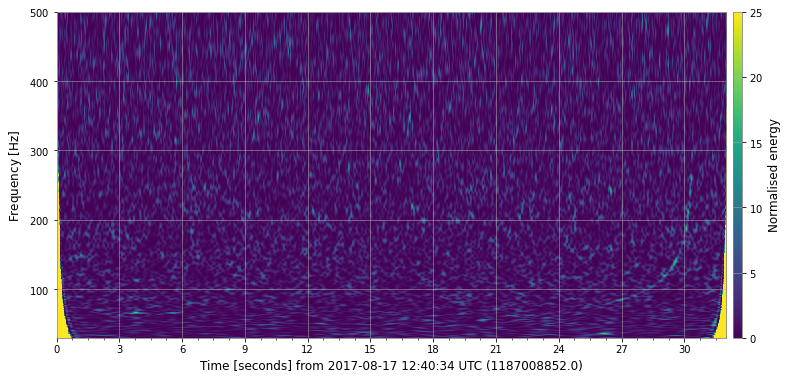

In [24]:
sq = sqt(hdata, frange=(30, 500))
#default qrange = (4, 64)

plot = sq.plot()
plot.colorbar(label="Normalised energy", clim=[0, 25])

### S Transform